Environment: folium: True plotly: True tensorflow: True
Loading dataset from: US_Accidents_March23.parquet
Raw shape: (7728394, 46)
Shape after dedupe: (7728394, 46)
Sampling 200000 rows (SAMPLE_MODE=True).
Shape after sampling: (200000, 46)
Columns available and used: ['Severity', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Weather_Condition', 'Traffic_Signal', 'Junction', 'Source', 'Wind_Direction', 'Start_Time', 'State', 'County', 'City', 'Start_Lat', 'Start_Lng']
Parsing Start_Time (robust)...
Start_Time parsed: 200000 non-null (100.0%)
Severity value counts (sample):
Severity
2    159136
3     33809
4      5356
1      1699
Name: count, dtype: int64
After dropping missing Severity shape: (200000, 19)
Unique severity values: [1, 2, 3, 4]
Numeric: ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']
Categorical: ['Weather_Condition', 'Traffic_Signal', 'Junction', 'Source', 'Wind_Direction']
Location: ['State', 'Co

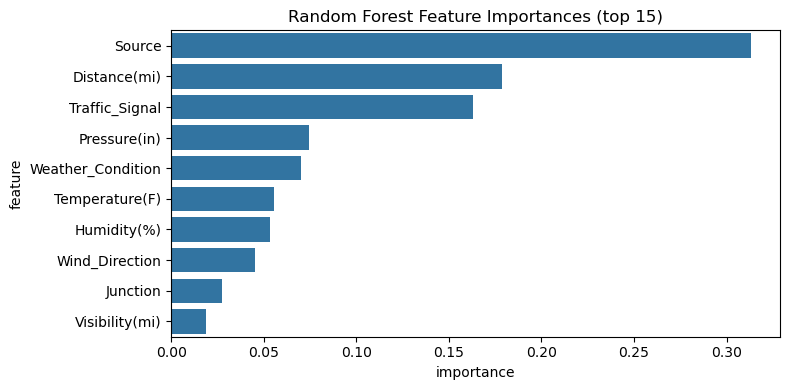

In [4]:
# %% [markdown]
# # Accident Severity Pipeline (robust, memory-aware)
# This notebook-style script:
# - Loads a Parquet US Accidents dataset (robust parsing)
# - Fixes duplicate column names
# - Fixes Start_Time parsing issues (handles ".000000000" and mixed ISO formats)
# - Samples for memory efficiency (configurable)
# - Preprocesses numeric & categorical features
# - Splits by year with test = 2022 & 2023
# - Trains RandomForest baseline; extracts permutation & RF importances
# - Optional: trains Transformer and LSTM (only if TensorFlow available)
# - Clusters cities/states and creates geospatial outputs (folium & plotly)
# - Produces model comparison table
#
# BEFORE RUNNING: `pip install pandas pyarrow scikit-learn matplotlib seaborn folium plotly`
# Optional for deep: `pip install tensorflow`
#
# Edit DATA_PATH and SAMPLE_MODE as needed.

# %%
# Config
DATA_PATH = "US_Accidents_March23.parquet"    # <- change path to your parquet file
OUTPUT_DIR = "severity_outputs"
SAMPLE_MODE = True                 # True to sample for interactive runs (faster, lower memory)
SAMPLE_SIZE = 200_000              # sample size when SAMPLE_MODE=True
TEST_YEARS = [2022, 2023]          # test years
RANDOM_SEED = 42

# %%
# Imports
import os, gc, sys, math, warnings, traceback
warnings.filterwarnings("ignore")
os.makedirs(OUTPUT_DIR, exist_ok=True)

import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Optional libs (import safely)
try:
    import folium
    from folium.plugins import HeatMap
    FOLIUM_AVAILABLE = True
except Exception:
    FOLIUM_AVAILABLE = False

try:
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    TENSORFLOW_AVAILABLE = True
except Exception:
    TENSORFLOW_AVAILABLE = False

print("Environment: folium:", FOLIUM_AVAILABLE, "plotly:", PLOTLY_AVAILABLE, "tensorflow:", TENSORFLOW_AVAILABLE)

# %%
# Helper utilities
def safe_read_parquet(path):
    """Read parquet robustly, trying pyarrow then fastparquet (if available)."""
    try:
        return pd.read_parquet(path, engine='pyarrow')
    except Exception as e1:
        try:
            return pd.read_parquet(path, engine='fastparquet')
        except Exception as e2:
            print("Failed to read parquet with pyarrow and fastparquet.")
            raise

def coerce_start_time(series):
    """Robust Start_Time parsing:
       - convert to str
       - remove trailing '.000000000' style nanoseconds if present
       - try pd.to_datetime with infer; fallback to elementwise parsing
    """
    s = series.astype(str).copy()
    # remove common trailing fractional patterns like .000000000 or .000000
    s = s.str.replace(r'\.0{3,9}$', '', regex=True)
    s = s.replace({'nan': None})
    # attempt vectorized parse
    try:
        parsed = pd.to_datetime(s, errors='coerce', infer_datetime_format=True)
        # if too many NaT, try mixed inference
        nan_pct = parsed.isna().mean()
        if nan_pct > 0.2:
            # fallback: elementwise parsing
            parsed = pd.Series([pd.to_datetime(x, errors='coerce') for x in s])
    except Exception:
        parsed = pd.Series([pd.to_datetime(x, errors='coerce') for x in s])
    return parsed

def remove_duplicate_columns(df):
    """Remove duplicate column names, keep first occurrence.
       Also print duplicates for debugging."""
    dupes = df.columns[df.columns.duplicated()].tolist()
    if dupes:
        print("Duplicate columns detected (will keep first occurrences):", sorted(set(dupes)))
        df = df.loc[:, ~df.columns.duplicated()]
    return df

# %%
# 1) Load dataset
print("Loading dataset from:", DATA_PATH)
df = safe_read_parquet(DATA_PATH)
print("Raw shape:", df.shape)

# 1a) Remove duplicate columns
df = remove_duplicate_columns(df)
print("Shape after dedupe:", df.shape)

# 1b) Optionally sample for memory efficiency
if SAMPLE_MODE and df.shape[0] > SAMPLE_SIZE:
    print(f"Sampling {SAMPLE_SIZE} rows (SAMPLE_MODE=True).")
    df = df.sample(SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)
    print("Shape after sampling:", df.shape)

# %%
# 2) Column selection - keep only necessary features (from conversation)
wanted = [
    'Severity', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Weather_Condition', 'Traffic_Signal', 'Junction',
    'Source', 'Wind_Direction', 'Start_Time', 'State', 'County', 'City', 'Start_Lat', 'Start_Lng'
]
cols_present = [c for c in wanted if c in df.columns]
print("Columns available and used:", cols_present)
df = df[cols_present].copy()

# 2a) Parse Start_Time robustly (fixes the ValueError about '.000000000')
if 'Start_Time' in df.columns:
    print("Parsing Start_Time (robust)...")
    df['Start_Time_parsed'] = coerce_start_time(df['Start_Time'])
    # if parsing failed to produce any non-null values, try pandas default once more
    if df['Start_Time_parsed'].notna().sum() == 0:
        df['Start_Time_parsed'] = pd.to_datetime(df['Start_Time'], errors='coerce', infer_datetime_format=True)
    # If still many NaT, keep original as-is; otherwise use parsed
    null_frac = df['Start_Time_parsed'].isna().mean()
    print(f"Start_Time parsed: {df['Start_Time_parsed'].notna().sum()} non-null ({(1-null_frac)*100:.1f}%)")
    df['Start_Time'] = df['Start_Time_parsed']
    df.drop(columns=['Start_Time_parsed'], inplace=True)
    # Extract year/hour/day
    df['year'] = df['Start_Time'].dt.year
    df['hour'] = df['Start_Time'].dt.hour
else:
    df['year'] = pd.NA
    df['hour'] = pd.NA

# 2b) Ensure Severity is numeric & not NA
if 'Severity' not in df.columns:
    raise RuntimeError("Target 'Severity' not found in dataset columns.")
# coerce to numeric, preserve missing
df['Severity'] = pd.to_numeric(df['Severity'], errors='coerce')
print("Severity value counts (sample):")
print(df['Severity'].value_counts(dropna=False).head(20))

# Drop rows with missing Severity
df = df.dropna(subset=['Severity'])
df['Severity'] = df['Severity'].astype(int)
print("After dropping missing Severity shape:", df.shape)
print("Unique severity values:", sorted(df['Severity'].unique()))

# %%
# 3) Define numeric & categorical features (only those present)
numeric_features = [c for c in ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)'] if c in df.columns]
categorical_features = [c for c in ['Weather_Condition', 'Traffic_Signal', 'Junction', 'Source', 'Wind_Direction'] if c in df.columns]
location_features = [c for c in ['State', 'County', 'City', 'Start_Lat', 'Start_Lng'] if c in df.columns]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)
print("Location:", location_features)

# Basic missing handling: numeric -> median, categorical -> 'MISSING'
for n in numeric_features:
    df[n] = pd.to_numeric(df[n], errors='coerce')
    med = df[n].median()
    df[n] = df[n].fillna(med)

for c in categorical_features:
    df[c] = df[c].fillna('MISSING').astype(str)

# Keep only rows with at least some numeric signal
if numeric_features:
    df = df.dropna(subset=numeric_features, how='all')
print("Post-clean shape:", df.shape)

# %%
# 4) Train/test split by year (test = 2022 & 2023). If no years, fallback to random split
if 'year' in df.columns and df['year'].notna().sum() > 0:
    train_df = df[~df['year'].isin(TEST_YEARS)].copy()
    test_df = df[df['year'].isin(TEST_YEARS)].copy()
    if train_df.shape[0] < 1000:  # fallback
        print("Too few train rows by year split; falling back to year < min(TEST_YEARS)")
        train_df = df[df['year'] < min(TEST_YEARS)].copy()
        test_df = df[df['year'].isin(TEST_YEARS)].copy()
    if test_df.shape[0] == 0:  # fallback to random split
        print("No rows in test years; using random 80/20 split.")
        train_df = df.sample(frac=0.8, random_state=RANDOM_SEED)
        test_df = df.drop(train_df.index)
else:
    print("No valid 'year' info found; using random 80/20 split.")
    train_df = df.sample(frac=0.8, random_state=RANDOM_SEED)
    test_df = df.drop(train_df.index)

print("Train/test shapes:", train_df.shape, test_df.shape)

# %%
# 5) Encode target 'Severity' to 0..K-1 (LabelEncoder) to make TensorFlow happy
le_target = LabelEncoder()
train_df['Severity_enc'] = le_target.fit_transform(train_df['Severity'])
test_df['Severity_enc'] = le_target.transform(test_df['Severity'])
num_classes = len(le_target.classes_)
print("Label mapping (original -> encoded):", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))
print("Number of classes:", num_classes)

# Save mapping for reference
mapping_df = pd.DataFrame({"original": le_target.classes_, "encoded": le_target.transform(le_target.classes_)})
mapping_df.to_csv(os.path.join(OUTPUT_DIR, "severity_label_mapping.csv"), index=False)

# %%
# 6) Preprocess features: encode categoricals (OrdinalEncoder), scale numerics (StandardScaler)
# Fit encoders on train only
enc_cat = None
if categorical_features:
    enc_cat = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[categorical_features] = enc_cat.fit_transform(train_df[categorical_features])
    test_df[categorical_features] = enc_cat.transform(test_df[categorical_features])

scaler = None
if numeric_features:
    scaler = StandardScaler()
    train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
    test_df[numeric_features] = scaler.transform(test_df[numeric_features])

feature_cols = numeric_features + categorical_features
print("Final feature columns:", feature_cols)

X_train = train_df[feature_cols].values
y_train = train_df['Severity_enc'].values
X_test = test_df[feature_cols].values
y_test = test_df['Severity_enc'].values

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

# free memory
gc.collect()

# %%
# 7) Model A: RandomForest baseline (memory-conscious)
print("\n=== Training RandomForest baseline ===")
rf = RandomForestClassifier(n_estimators=80, max_depth=12, random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("\nRandomForest classification report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
print(f"RF accuracy: {rf_acc:.4f}, f1_macro: {rf_f1:.4f}")

# Permutation importance (on a sample if test set large)
print("Computing permutation importance...")
try:
    perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED, n_jobs=-1)
    perm_idx = np.argsort(perm.importances_mean)[::-1]
    perm_df = pd.DataFrame({
        "feature": [feature_cols[i] for i in perm_idx],
        "importance_mean": perm.importances_mean[perm_idx]
    })
    perm_df.to_csv(os.path.join(OUTPUT_DIR, "rf_permutation_importance.csv"), index=False)
    print("Top permutation-import features:\n", perm_df.head(10))
except Exception as e:
    print("Permutation importance failed:", e)

# RF feature importances
fi = pd.DataFrame({"feature": feature_cols, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
fi.to_csv(os.path.join(OUTPUT_DIR, "rf_feature_importance.csv"), index=False)

# Plot top importances
plt.figure(figsize=(8, max(4, 0.3*len(fi.head(15)))))
sns.barplot(x='importance', y='feature', data=fi.head(15))
plt.title("Random Forest Feature Importances (top 15)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "rf_feature_importance.png"))
plt.show()

# %%


In [5]:
# 8) Clustering: City/State-level severity clusters
if 'City' in df.columns and 'State' in df.columns:
    print("\n=== Clustering cities by mean severity ===")
    loc = df.groupby(['State', 'City']).agg(
        severity_mean=('Severity', 'mean'),
        count=('Severity', 'count'),
        lat=('Start_Lat', 'mean') if 'Start_Lat' in df.columns else pd.NamedAgg(column='Severity', aggfunc=lambda x: np.nan),
        lon=('Start_Lng', 'mean') if 'Start_Lng' in df.columns else pd.NamedAgg(column='Severity', aggfunc=lambda x: np.nan)
    ).reset_index().dropna(subset=['severity_mean'])
    # encode State & City for clustering
    loc_enc = OrdinalEncoder()
    loc[['State_enc', 'City_enc']] = loc_enc.fit_transform(loc[['State', 'City']].astype(str))
    cluster_feats = ['severity_mean', 'State_enc', 'City_enc']
    k = min(8, max(2, int(math.sqrt(len(loc)))))
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    loc['cluster'] = kmeans.fit_predict(loc[cluster_feats])
    loc.to_csv(os.path.join(OUTPUT_DIR, "city_severity_clusters.csv"), index=False)
    print("Cluster summary:")
    print(
    loc.groupby('cluster')[['severity_mean', 'count']]
    .agg(['mean', 'sum', 'count'])
    .head())
else:
    print("City/State not present - skipping clustering.")

# %%
# 9) Optional deep models: Transformer & LSTM (only if tensorflow available)
results = []
if TENSORFLOW_AVAILABLE:
    try:
        # Determine number of classes for final layer (from label encoder)
        n_classes = num_classes
        print("\nTensorFlow found. Building Transformer (light) with", n_classes, "classes.")

        # Prepare Transformer input: shape (samples, seq_len, 1) where seq_len = number of features
        seq_len = X_train.shape[1]
        Xtr_tf = X_train.reshape((-1, seq_len, 1))
        Xts_tf = X_test.reshape((-1, seq_len, 1))

        # Build a compact Transformer-like model using MultiHeadAttention
        inputs = layers.Input(shape=(seq_len, 1))
        # project features into embedding dim
        proj = layers.TimeDistributed(layers.Dense(16, activation='relu'))(inputs)
        att = layers.MultiHeadAttention(num_heads=2, key_dim=8)(proj, proj)
        x = layers.GlobalAveragePooling1D()(att)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(n_classes, activation='softmax')(x)
        transformer_model = models.Model(inputs=inputs, outputs=outputs)
        transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Fit with small batch and few epochs to avoid OOM
        transformer_model.fit(Xtr_tf, y_train, epochs=6, batch_size=512, validation_split=0.05, verbose=1)
        tf_preds = transformer_model.predict(Xts_tf, batch_size=512).argmax(axis=1)
        print("\nTransformer classification report:")
        print(classification_report(y_test, tf_preds, zero_division=0))
        tf_acc = accuracy_score(y_test, tf_preds)
        tf_f1 = f1_score(y_test, tf_preds, average='macro')
        results.append({'model': 'Transformer', 'accuracy': tf_acc, 'f1_macro': tf_f1})

    except Exception as e:
        print("Transformer training failed:", e)
        traceback.print_exc()

    # LSTM: only if we can make a small sequence dataset
    try:
        print("\nBuilding a light LSTM on sliding-window aggregated features...")
        # Create sliding windows of small size (e.g., window=5) using training data only to avoid leakage
        window = 5
        df_sorted = train_df.sort_values('Start_Time').copy() if 'Start_Time' in train_df.columns else train_df.copy()
        # Create simple windows by taking means of features in each window
        X_seq = []
        y_seq = []
        feat_names = feature_cols
        arr = df_sorted[feat_names].values
        lab = df_sorted['Severity_enc'].values
        for i in range(window, len(arr)):
            # use previous 'window' events' mean as input and label is current
            X_seq.append(arr[i-window:i].mean(axis=0))
            y_seq.append(lab[i])
            if len(X_seq) >= 50_000:  # limit to 50k windows to control memory
                break
        if len(X_seq) > 0:
            X_seq = np.array(X_seq)
            y_seq = np.array(y_seq)
            X_seq = X_seq.reshape((X_seq.shape[0], 1, X_seq.shape[1]))  # (samples, timesteps=1, features)
            # build small LSTM
            lstm_inputs = layers.Input(shape=(1, X_seq.shape[2]))
            lstm = layers.LSTM(64)(lstm_inputs)
            l = layers.Dense(32, activation='relu')(lstm)
            out = layers.Dense(n_classes, activation='softmax')(l)
            lstm_model = models.Model(inputs=lstm_inputs, outputs=out)
            lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            lstm_model.fit(X_seq, y_seq, epochs=4, batch_size=1024, verbose=1)
            # Evaluate on last slice (quick check)
            lstm_preds = lstm_model.predict(X_seq[-min(len(y_test), len(X_seq)):]).argmax(axis=1)
            print("\nLSTM sample classification report:")
            print(classification_report(y_seq[-len(lstm_preds):], lstm_preds, zero_division=0))
            lstm_acc = (lstm_preds == y_seq[-len(lstm_preds):]).mean()
            lstm_f1 = f1_score(y_seq[-len(lstm_preds):], lstm_preds, average='macro')
            results.append({'model': 'LSTM_sample', 'accuracy': lstm_acc, 'f1_macro': lstm_f1})
        else:
            print("Not enough sequential data for LSTM windows; skipping LSTM.")
    except Exception as e:
        print("LSTM training failed:", e)
        traceback.print_exc()
else:
    print("\nTensorFlow not available — skipping Transformer & LSTM (you can install tensorflow to enable these).")

# Always append classical RF results
results.append({'model': 'RandomForest', 'accuracy': rf_acc, 'f1_macro': rf_f1})

# %%
# 10) Geospatial visualizations (folium heatmap & plotly choropleth by state)
print("\n=== Geospatial outputs ===")
# Folium heatmap (sampled points to limit size)
if FOLIUM_AVAILABLE and 'Start_Lat' in df.columns and 'Start_Lng' in df.columns:
    try:
        geo_df = df[['Start_Lat', 'Start_Lng', 'Severity']].dropna()
        sample_n = min(len(geo_df), 100000)
        geo_sample = geo_df.sample(sample_n, random_state=RANDOM_SEED)
        base_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
        HeatMap(geo_sample[['Start_Lat', 'Start_Lng', 'Severity']].values.tolist(), radius=6, blur=4, max_zoom=10).add_to(base_map)
        heatmap_path = os.path.join(OUTPUT_DIR, "severity_heatmap_USA.html")
        base_map.save(heatmap_path)
        print("Saved folium heatmap to", heatmap_path)
    except Exception as e:
        print("Failed to build folium heatmap:", e)
else:
    print("Skipping folium heatmap (missing folium or lat/lng columns).")

# Plotly choropleth by state (requires state abbreviations)
if PLOTLY_AVAILABLE and 'State' in df.columns:
    try:
        state_df = df.groupby('State')['Severity'].mean().reset_index()
        choropleth_path = os.path.join(OUTPUT_DIR, "severity_state_choropleth.html")
        fig = px.choropleth(state_df, locations='State', locationmode='USA-states', color='Severity',
                            scope='usa', color_continuous_scale='Reds', title='Average Accident Severity by State')
        fig.write_html(choropleth_path)
        print("Saved state choropleth to", choropleth_path)
    except Exception as e:
        print("Failed to build state choropleth:", e)
else:
    print("Skipping state choropleth (missing plotly or State column).")

# %%
# 11) Model comparison summary and save
comp_df = pd.DataFrame(results)
print("\nModel comparison:")
print(comp_df)

comp_df.to_csv(os.path.join(OUTPUT_DIR, "model_comparison.csv"), index=False)
print("Saved model comparison to", os.path.join(OUTPUT_DIR, "model_comparison.csv"))

# Save rf predictions joined to test sample for further inspection
try:
    out_pred = test_df.head(20000).copy()  # avoid huge writes
    out_pred['rf_pred_encoded'] = y_pred_rf[:len(out_pred)]
    out_pred['rf_pred_orig'] = le_target.inverse_transform(out_pred['rf_pred_encoded'])
    out_pred['severity_orig'] = le_target.inverse_transform(out_pred['Severity_enc'])
    out_pred.to_csv(os.path.join(OUTPUT_DIR, "test_preds_sample.csv"), index=False)
    print("Saved sample predictions to", os.path.join(OUTPUT_DIR, "test_preds_sample.csv"))
except Exception as e:
    print("Could not save test preds:", e)

# %%
# 12) Final notes & cleanup
print("\nPipeline complete. Outputs saved to:", OUTPUT_DIR)
print("If Transformer/LSTM were skipped, install tensorflow and re-run those cells.")
gc.collect()



=== Clustering cities by mean severity ===
Cluster summary:
        severity_mean                         count             
                 mean          sum count       mean    sum count
cluster                                                         
0            2.325451  3127.731157  1345  15.259480  20524  1345
1            2.299792  2851.742003  1240  23.409677  29028  1240
2            2.315661  3028.884217  1308  22.811927  29838  1308
3            2.339887  3074.611788  1314  18.441400  24232  1314
4            2.296710  2866.294202  1248  13.280449  16574  1248

TensorFlow found. Building Transformer (light) with 4 classes.
Epoch 1/6
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7533 - loss: 0.7145 - val_accuracy: 0.7587 - val_loss: 0.6590
Epoch 2/6
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7534 - loss: 0.6590 - val_accuracy: 0.7587 - val_loss: 0.6564
Epoch 3/6
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7534 - loss: 0.6570 - val_accurac

4213

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ==========================================
#  LOGISTIC REGRESSION MODEL
# ==========================================
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)     # Use scaled data if you scaled others
y_pred_lr = log_reg.predict(X_test_scaled)

print("\n===== LOGISTIC REGRESSION =====")
print(classification_report(y_test, y_pred_lr))
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", lr_accuracy)

model_scores["Logistic Regression"] = lr_accuracy  # add to summary dictionary





===== LOGISTIC REGRESSION =====
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       944
           1       0.92      0.99      0.96     47295
           2       0.35      0.09      0.15      2023
           3       0.05      0.00      0.01      1337

    accuracy                           0.91     51599
   macro avg       0.33      0.27      0.28     51599
weighted avg       0.86      0.91      0.88     51599

Accuracy: 0.9139130603306266


NameError: name 'model_scores' is not defined

In [8]:
# ==========================================
#  XGBOOST MODEL
# ==========================================
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'   # prevents warnings
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n===== XGBOOST =====")
print(classification_report(y_test, y_pred_xgb))
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", xgb_accuracy)

model_scores["XGBoost"] = xgb_accuracy  # add to summary dictionary


===== XGBOOST =====
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       944
           1       0.92      1.00      0.96     47295
           2       0.48      0.13      0.21      2023
           3       0.33      0.00      0.00      1337

    accuracy                           0.92     51599
   macro avg       0.43      0.28      0.29     51599
weighted avg       0.87      0.92      0.89     51599

Accuracy: 0.9173821198085235


NameError: name 'model_scores' is not defined